In [1]:
import os
import cv2
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

Using TensorFlow backend.


In [2]:
from SqueezeDetHelpers import get_all_points_from_prediction
from Models.PoolingAndFire import create_loss_function_multiple_detection
from PreProcess import *

In [3]:
MODEL_FILE = os.path.expanduser("~/results/SqueezeDet/all_points.h5py")
#MODEL_FILE = os.path.expanduser("~/results/SqueezeDet/all_points_complete_run_09.h5py")
#MODEL_FILE = os.path.expanduser("~/results/SqueezeDet/all_points_overfit_32.h5py")
RHD_ANNOTATIONS_FILE = os.path.expanduser("~/datasets/RHD/RHD_published_v2/training/anno_training.pickle")
VALIDATION_DIR = os.path.expanduser("~/datasets/RHD/processed/validation")
TRAIN_DIR = os.path.expanduser("~/datasets/RHD/processed/train")
VALIDATION_ANNOTATIONS = os.path.expanduser("~/datasets/RHD/processed/validation/annotations/")
TRAIN_ANNOTATIONS = os.path.expanduser("~/datasets/RHD/processed/train/annotations/")

In [4]:
create_rhd_annotations(RHD_ANNOTATIONS_FILE,
                       VALIDATION_ANNOTATIONS,
                       VALIDATION_DIR,
                       fingers='ALL',
                       hands_to_annotate='BOTH',
                       annotate_non_visible=False,
                       force_new_files=True)

 12%|█▏        | 478/4126 [00:00<00:00, 4777.86it/s]

Creating annotations in directory: /home/clh/datasets/RHD/processed/validation
Using annotation file: /home/clh/datasets/RHD/RHD_published_v2/training/anno_training.pickle
And outputting to: /home/clh/datasets/RHD/processed/validation/annotations/


100%|██████████| 4126/4126 [00:00<00:00, 4711.87it/s]

In [5]:
BATCHSIZE = 64
EPSILON = 1e-16

LABEL_WEIGHT = 1.0
OFFSET_LOSS_WEIGHT = 1.0
OFFSET_SCALE = int(320 / 20) / 2

NUM_CLASSES = 42

l = create_loss_function_multiple_detection(20,
                                            20,
                                            LABEL_WEIGHT,
                                            OFFSET_SCALE,
                                            OFFSET_LOSS_WEIGHT,
                                            NUM_CLASSES,
                                            EPSILON,
                                            BATCHSIZE)

In [6]:
model = load_model(MODEL_FILE, custom_objects={'loss_function': l})

In [7]:
samples_dir = TRAIN_DIR
annotations_dir = TRAIN_ANNOTATIONS

In [8]:
NUM_SAMPLES_TO_CHECK = 10

samples_to_check = []
for fi in os.listdir(samples_dir):
    if fi.endswith('png'):
        samples_to_check.append(int(fi.split('.')[0]))
        if len(samples_to_check) >= NUM_SAMPLES_TO_CHECK:
            break

print(samples_to_check)

[2671, 13691, 11388, 16081, 2962, 29984, 15841, 2587, 22410, 33917]


In [9]:
#labels, images = load_data_with_anchors(samples_to_check,
#                                        DATA_DIR,
#                                        ANNOTATIONS_PATH,
#                                        320, 320,
#                                        20, 20,
#                                        'png',
#                                        num_classes=NUM_CLASSES)

#overfit_sample = range(10)
#samples_to_check = overfit_sample
labels, images = load_data_with_anchors(samples_to_check,
                                        samples_dir,
                                        annotations_dir,
                                        320, 320,
                                        20, 20,
                                        OFFSET_SCALE,
                                        'png',
                                        num_classes=NUM_CLASSES,
                                        greyscale=True)

images_show = np.zeros((len(images), 320, 320, 3), dtype=np.uint8)
for c, im in enumerate(images):
    #images_show[c] = cv2.cvtColor((im * 255.0).astype(np.uint8), cv2.COLOR_BGR2RGB)
    images_show[c][:, :, 0] = im.reshape(320, 320) * 255.0
    images_show[c][:, :, 1] = im.reshape(320, 320) * 255.0
    images_show[c][:, :, 2] = im.reshape(320, 320) * 255.0

print(np.max(images[0]))

0.9294117647058824


In [10]:

for l in labels:
    print(l.shape)
    for i in range(NUM_CLASSES):
        offset_xs = l[:, :, NUM_CLASSES+i*2]
        offset_ys = l[:, :, NUM_CLASSES+1+i*2]
        
        print(f"Offset max x: {np.max(offset_xs)}")
        print(f"Offset max y: {np.max(offset_ys)}")
        print("")

(20, 20, 126)
Offset max x: 2.1875
Offset max y: 1.7999992370605469

Offset max x: 1.2374992370605469
Offset max y: 1.4624996185302734

Offset max x: 2.0375003814697266
Offset max y: 1.9125003814697266

Offset max x: 2.2875003814697266
Offset max y: 2.3999996185302734

Offset max x: 1.3875007629394531
Offset max y: 2.262500762939453

Offset max x: 2.174999237060547
Offset max y: 2.2749996185302734

Offset max x: 0.9249992370605469
Offset max y: 1.9750003814697266

Offset max x: 1.5375003814697266
Offset max y: 1.75

Offset max x: 1.8125
Offset max y: 1.2625007629394531

Offset max x: 1.0750007629394531
Offset max y: 2.387500762939453

Offset max x: 1.4624996185302734
Offset max y: 2.637500762939453

Offset max x: 1.8999996185302734
Offset max y: 2.7250003814697266

Offset max x: 1.9874992370605469
Offset max y: 2.4624996185302734

Offset max x: 2.375
Offset max y: 2.512500762939453

Offset max x: 1.1000003814697266
Offset max y: 1.1124992370605469

Offset max x: 1.6749992370605469
Offs

In [11]:
right_hand = []
left_hand = []

with open(RHD_ANNOTATIONS_FILE, 'rb') as f:
    annotations = pickle.load(f)
    
for s in samples_to_check:
    right_hand.append(get_right_hand(s, annotations))
    left_hand.append(get_left_hand(s, annotations))

In [12]:
"""
for c, h in enumerate(right_hand):
    for finger, point in h.items():
        p = point[:2]
        if p[0] < 0 or p[1] < 0:
            continue
        print(f"Right hand point: ({p[0]}, {p[1]})")
        cv2.circle(images_show[c], (p[0], p[1]), 1, (0, 0, 255), thickness=1)
    
for c, h in enumerate(left_hand):
    for finger, point in h.items():
        p = point[:2]
        if p[0] < 0 or p[1] < 0:
            continue
        cv2.circle(images_show[c], (p[0], p[1]), 1, (0, 0, 255), thickness=1)
"""

'\nfor c, h in enumerate(right_hand):\n    for finger, point in h.items():\n        p = point[:2]\n        if p[0] < 0 or p[1] < 0:\n            continue\n        print(f"Right hand point: ({p[0]}, {p[1]})")\n        cv2.circle(images_show[c], (p[0], p[1]), 1, (0, 0, 255), thickness=1)\n    \nfor c, h in enumerate(left_hand):\n    for finger, point in h.items():\n        p = point[:2]\n        if p[0] < 0 or p[1] < 0:\n            continue\n        cv2.circle(images_show[c], (p[0], p[1]), 1, (0, 0, 255), thickness=1)\n'

In [13]:
res = np.zeros(labels.shape)
process_times = []
for c, im in enumerate(images):
    before = time.time()
    #res.append(model.predict(im.reshape(1, 320, 320, 1)))
    res[c] = model.predict(im.reshape(1, 320, 320, 1))
    process_times.append(time.time() - before)
    
process_times = np.array(process_times)
print(f"Average processing time: {np.mean(process_times)}")
print(f"Max processing time: {np.max(process_times)}")
print(f"Min processing time: {np.min(process_times)}")
print(f"Average processing time excepting first: {np.mean(process_times[1:])}")

Average processing time: 0.216772198677063
Max processing time: 1.9902892112731934
Min processing time: 0.01937270164489746
Average processing time excepting first: 0.019714752833048504


In [14]:
for c, l in enumerate(labels):
    for i in range(NUM_CLASSES):
        single_label = np.zeros((20, 20, 3))
        single_label[:, :, 0] = labels[c, :, :, i]
        single_label[:, :, 1] = labels[c, :, :, NUM_CLASSES+i*2]
        single_label[:, :, 2] = labels[c, :, :, NUM_CLASSES+1+i*2]
        
        anchors = get_anchors(320, 320, 20, 20)

        label_points = get_all_points_from_prediction(single_label,
                                                      anchors,
                                                      threshold=1.0,
                                                      offset_weight=OFFSET_SCALE)
        
        for p in label_points:
            x = p[0] + p[2]
            y = p[1] + p[3]
            
            #print(f"Label point: ({x}, {y})")
            #print(f"\tOffset: ({p[2]}, {p[3]})")
            print(f"Label point: ({x}, {y}), offset: ({p[2]}, {p[3]})")

            cv2.circle(images_show[c], (int(x), int(y)), 1, (0, 255, 0), thickness=2)
        

Label point: (154.5, 181.39999389648438), offset: (2.5, -0.600006103515625)
Label point: (191.89999389648438, 148.6999969482422), offset: (-6.100006103515625, -3.3000030517578125)
Label point: (183.3000030517578, 152.3000030517578), offset: (1.3000030517578125, 0.3000030517578125)
Label point: (170.3000030517578, 156.1999969482422), offset: (3.3000030517578125, 4.1999969482421875)
Label point: (163.10000610351562, 170.10000610351562), offset: (-3.899993896484375, 3.100006103515625)
Label point: (215.39999389648438, 185.1999969482422), offset: (2.399993896484375, 3.1999969482421875)
Label point: (205.39999389648438, 182.8000030517578), offset: (7.399993896484375, 0.8000030517578125)
Label point: (194.3000030517578, 181.0), offset: (-3.6999969482421875, -1.0)
Label point: (181.5, 177.10000610351562), offset: (-0.5, -4.899993896484375)
Label point: (221.60000610351562, 186.10000610351562), offset: (-6.399993896484375, 4.100006103515625)
Label point: (209.6999969482422, 188.10000610351562)

Label point: (171.8000030517578, 143.3000030517578), offset: (4.8000030517578125, 6.3000030517578125)
Label point: (153.10000610351562, 181.89999389648438), offset: (1.100006103515625, -0.100006103515625)
Label point: (145.39999389648438, 167.5), offset: (-6.600006103515625, 0.5)
Label point: (145.3000030517578, 150.6999969482422), offset: (-6.6999969482421875, -1.3000030517578125)
Label point: (155.3000030517578, 144.3000030517578), offset: (3.3000030517578125, 7.3000030517578125)
Label point: (195.1999969482422, 226.6999969482422), offset: (-2.8000030517578125, -1.3000030517578125)
Label point: (190.0, 198.3000030517578), offset: (8.0, 0.3000030517578125)
Label point: (189.89999389648438, 176.60000610351562), offset: (7.899993896484375, -5.399993896484375)
Label point: (181.39999389648438, 157.6999969482422), offset: (-0.600006103515625, 5.6999969482421875)
Label point: (191.1999969482422, 261.1000061035156), offset: (-6.8000030517578125, 2.100006103515625)
Label point: (198.19999694

In [15]:
THRESHOLD = 0.9

for c, r in enumerate(res):
    #print(r.shape)
    #pred = r.reshape(20, 20, 3)
    
    for i in range(NUM_CLASSES):
        pred = np.zeros((20, 20, 3))
        
        pred[:, :, 0] = res[c, :, :, i]
        pred[:, :, 1] = res[c, :, :, NUM_CLASSES+i*2]
        pred[:, :, 2] = res[c, :, :, NUM_CLASSES+1+i*2]
        
        #print(np.max(pred[:, :, 0]))
        
        anchors = get_anchors(320, 320, 20, 20)
        #max_val = np.max(pred[:,:,0])
        max_val = 0.9
        pred_point = get_all_points_from_prediction(pred,
                                                    anchors,
                                                    threshold=max_val,
                                                    offset_weight=OFFSET_SCALE,
                                                    is_label=False)
        
        for p in pred_point:
            x = p[0] + p[2]
            y = p[1] + p[3]
            
            print(f"Predicted point: ({x}, {y}), confidence: {max_val}")

            cv2.circle(images_show[c], (int(x), int(y)), 1, (255, 0, 0), thickness=1)

Predicted point: (153.28186893463135, 188.87375450134277), confidence: 0.9
Predicted point: (189.2891845703125, 148.67505502700806), confidence: 0.9
Predicted point: (185.77758979797363, 158.29286575317383), confidence: 0.9
Predicted point: (161.92765021324158, 161.1579122543335), confidence: 0.9
Predicted point: (182.95197677612305, 174.61110877990723), confidence: 0.9
Predicted point: (220.80723667144775, 189.1261510848999), confidence: 0.9
Predicted point: (208.95414233207703, 189.57738494873047), confidence: 0.9
Predicted point: (175.49919855594635, 187.22993087768555), confidence: 0.9
Predicted point: (215.49255847930908, 189.91565418243408), confidence: 0.9
Predicted point: (205.43170782923698, 189.97189712524414), confidence: 0.9
Predicted point: (190.7661485671997, 191.0012276172638), confidence: 0.9
Predicted point: (179.12975358963013, 189.93352603912354), confidence: 0.9
Predicted point: (179.12975358963013, 205.93352603912354), confidence: 0.9
Predicted point: (218.74050998

Predicted point: (61.40848922729492, 7.9842817187309265), confidence: 0.9
Predicted point: (57.59133958816528, 11.245699882507324), confidence: 0.9
Predicted point: (174.39524269104004, 129.09620890021324), confidence: 0.9
Predicted point: (205.59919261932373, 123.91685104370117), confidence: 0.9
Predicted point: (150.09804964065552, 180.9370379447937), confidence: 0.9
Predicted point: (162.86874890327454, 166.42694234848022), confidence: 0.9
Predicted point: (182.91232585906982, 145.38245332241058), confidence: 0.9
Predicted point: (157.85826683044434, 191.78346848487854), confidence: 0.9
Predicted point: (163.66609048843384, 179.8577380180359), confidence: 0.9
Predicted point: (175.56877851486206, 172.50639533996582), confidence: 0.9
Predicted point: (124.83127975463867, 249.7478494644165), confidence: 0.9
Predicted point: (128.34789180755615, 243.3982629776001), confidence: 0.9
Predicted point: (189.34789180755615, 182.3982629776001), confidence: 0.9
Predicted point: (98.48965930938

In [16]:
def confidence_score(label, prediction, num_classes):
    """
    How often does the model tag the correct anchor.
    """
    error = 0
    for i in range(num_classes):
        l = label[:, :, i]
        p = prediction[:, :, i]
        
        label_x, label_y = np.where(l==1.0)
        try:
            label_point = np.array([label_x[0], label_y[0]])
            print(f"label_point: {label_point}")
        except:
            print("Error")
            continue

        prediction_x, prediction_y = np.where(p==np.max(p))
        prediction_point = np.array([prediction_x[0], prediction_y[0]])
        
        print(f"prediction_point: {prediction_point}")
        
        label_error = np.linalg.norm(label_point - prediction_point)
        error += label_error
        print(label_error)
        
        print("")
    
    return error

#print(res.shape)
confidence_score(labels[0], res[0], 42)

label_point: [ 9 11]
prediction_point: [ 9 11]
0.0

label_point: [12  9]
prediction_point: [11  9]
1.0

label_point: [11  9]
prediction_point: [11  9]
0.0

label_point: [10  9]
prediction_point: [11  9]
1.0

label_point: [10 10]
prediction_point: [10 10]
0.0

label_point: [13 11]
prediction_point: [13 11]
0.0

label_point: [12 11]
prediction_point: [12 11]
0.0

label_point: [12 11]
prediction_point: [12 10]
1.0

label_point: [11 11]
prediction_point: [11 10]
1.0

label_point: [14 11]
prediction_point: [13 11]
1.0

label_point: [13 11]
prediction_point: [13 11]
0.0

label_point: [12 11]
prediction_point: [12 12]
1.0

label_point: [11 11]
prediction_point: [11 11]
0.0

label_point: [13 11]
prediction_point: [13 11]
0.0

label_point: [13 12]
prediction_point: [13 11]
1.0

label_point: [12 12]
prediction_point: [12 12]
0.0

label_point: [11 12]
prediction_point: [11 12]
0.0

label_point: [13 12]
prediction_point: [13 12]
0.0

label_point: [12 12]
prediction_point: [12 12]
0.0

label_point:

11.0

In [17]:
p1 = np.array([9, 13])
p2 = np.array([10, 11])
print(np.linalg.norm(p1-p2))

2.23606797749979


In [18]:
def accuracy():
    pass

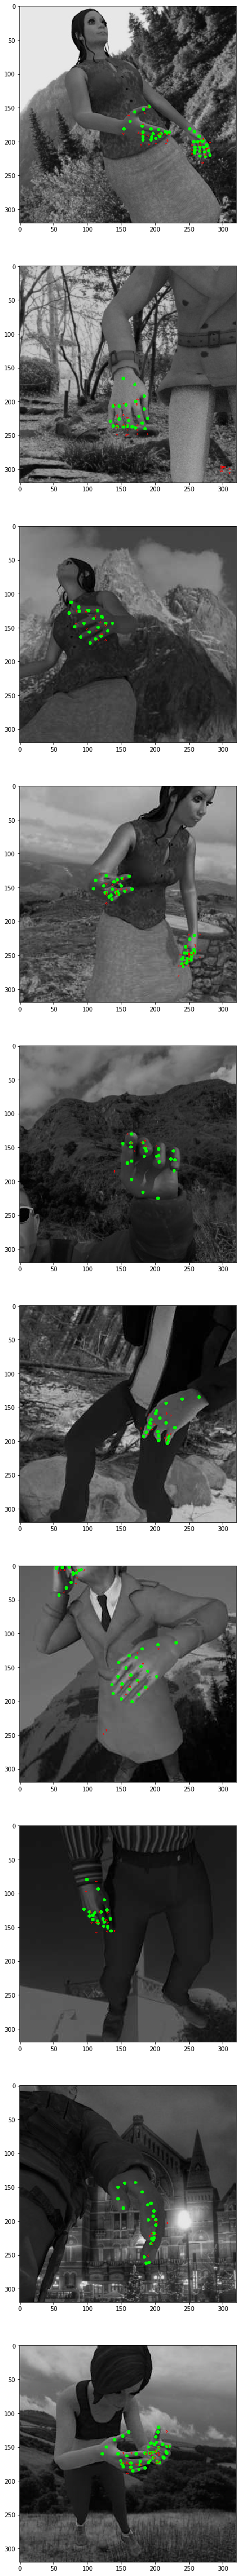

In [19]:
f, subs = plt.subplots(len(images_show), 1, figsize=(15, 8*len(samples_to_check)))
for c, im in enumerate(images_show):
    subs[c].imshow(im)
    #subs[c].set_title(f"Confidence: {np.max(res[c][:,:,:,0])}")

#f = plt.figure(figsize=(20, 20))
#plt.imshow(images_show[0], cmap='gray')